In [1]:
import numpy as np
import numba as nb
from sklearn.metrics._ranking import _binary_clf_curve
from sklearn import metrics

from crossfit.ml.classification import BinaryMetrics, BinaryCurveState

In [2]:
y_true = np.random.randint(2, size=1000).astype(np.float32)
y_pred = np.random.rand(1000)

In [3]:
import numpy as np


@nb.njit
def unsorted_segment_sum(arr, segment_ids, num_segments):
    # Create an empty array of the correct shape to hold the result
    result = np.zeros((num_segments,) + arr.shape[1:])

    # Loop through each segment and sum the values in the segment
    # into the corresponding entry in the result array
    for i in range(num_segments):
        result[i] = np.sum(arr[segment_ids == i], axis=0)

    return result


@nb.njit
def confusion_matrix_per_threshold(y_true, y_pred, num_thresholds):
    thresholds = np.linspace(0, 1, num_thresholds)
    bucket_indices = (np.ceil(y_pred * (num_thresholds - 1)) - 1).astype(np.int32)

    true_labels = y_true
    false_labels = 1.0 - y_true

    total_true_labels = true_labels.sum()
    total_false_labels = false_labels.sum()

    tp_bucket_v = unsorted_segment_sum(true_labels, bucket_indices, num_thresholds)
    fp_bucket_v = unsorted_segment_sum(false_labels, bucket_indices, num_thresholds)

    tp = np.cumsum(tp_bucket_v[::-1])[::-1]
    fp = np.cumsum(fp_bucket_v[::-1])[::-1]
    tn = total_false_labels - fp
    fn = total_true_labels - tp
    
    return tp, fp, tn, fn, thresholds
    

confusion_matrix_per_threshold(y_true, y_pred, 10)

(array([495., 439., 374., 324., 269., 225., 173., 122.,  55.,   0.]),
 array([505., 443., 393., 331., 261., 212., 156., 109.,  50.,   0.]),
 array([  0.,  62., 112., 174., 244., 293., 349., 396., 455., 505.]),
 array([  0.,  56., 121., 171., 226., 270., 322., 373., 440., 495.]),
 array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
        0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]))

In [4]:
thresholds = np.linspace(0, 1, 10) 
num_thresholds = len(thresholds)

bucket_indices = (np.ceil(y_pred * (num_thresholds - 1)) - 1).astype(np.int32)

true_labels = y_true
false_labels = 1.0 - y_true

total_true_labels = true_labels.sum()
total_false_labels = false_labels.sum()

tp_bucket_v = unsorted_segment_sum(true_labels, bucket_indices, num_thresholds)
fp_bucket_v = unsorted_segment_sum(false_labels, bucket_indices, num_thresholds)

tp = np.flip(np.flip(tp_bucket_v, 0).cumsum(), 0)
fp = np.flip(np.flip(fp_bucket_v, 0).cumsum(), 0)
tn = total_false_labels - fp
fn = total_true_labels - tp

print(tp[:5])
print(fp[:5])
print(tn[:5])
print(fn[:5])

[495. 439. 374. 324. 269.]
[505. 443. 393. 331. 261.]
[  0.  62. 112. 174. 244.]
[  0.  56. 121. 171. 226.]


In [7]:
split = 100

# fpr1, tpr1, thresholds1 = metrics.roc_curve(y_true[:split], y_pred[:split])
# fpr2, tpr2, thresholds2 = metrics.roc_curve(y_true[split:], y_pred[split:])

tuple1 = confusion_matrix_per_threshold(y_true[:split], y_pred[:split], 10)
tuple2 = confusion_matrix_per_threshold(y_true[split:], y_pred[split:], 5)
tp1, fp1, tn1, fn1, thresholds1 = tuple1 
tp2, fp2, tn2, fn2, thresholds2 = tuple2 


from collections import defaultdict 


def merge_histograms(hist1, hist2):
    _thresholds = (hist1[0], hist2[0])
    _fps = (hist1[1], hist2[1])
    
    longest_i = np.argmax([len(t) for t in _thresholds])
    shortest_i = 1 - longest_i

    # Interpolate the false-positive rates to have the same number of thresholds
    short_interp = np.interp(_thresholds[longest_i], _thresholds[shortest_i], _fps[shortest_i])
    long_interp = np.interp(_thresholds[longest_i], _thresholds[longest_i], _fps[longest_i])

    # Merge the false-positive rates by taking the maximum at each threshold
    fp_merged = short_interp + long_interp

    # Return the merged histogram
    return fp_merged, _thresholds[longest_i]


def merge(tuple1, tuple2): 
	tp1, fp1, tn1, fn1, thresholds1 = tuple1 
	tp2, fp2, tn2, fn2, thresholds2 = tuple2 
	
	tp = defaultdict(int) 
	fp = defaultdict(int) 
	tn = defaultdict(int) 
	fn = defaultdict(int) 
	
	for i in range(len(thresholds1)): 
		tp[thresholds1[i]] += tp1[i] 
		fp[thresholds1[i]] += fp1[i] 
		tn[thresholds1[i]] += tn1[i] 
		fn[thresholds1[i]] += fn1[i] 
		
	for i in range(len(thresholds2)): 
		tp[thresholds2[i]] += tp2[i] 
		fp[thresholds2[i]] += fp2[i] 
		tn[thresholds2[i]] += tn2[i] 
		fn[thresholds2[i]] += fn2[i] 
		
	return (
        np.array(list(tp.values())), 
        np.array(list(fp.values())), 
        np.array(list(tn.values())), 
        np.array(list(fn.values())), 
        np.array(list(tp.keys()))
    )


def merge_hist(a, b):
    edgesa = a[1]
    edgesb = b[1]
    da = edgesa[1]-edgesa[0]
    db = edgesb[1]-edgesb[0]
    dint = np.min([da, db])

    min = np.min(np.hstack([edgesa, edgesb]))
    max = np.max(np.hstack([edgesa, edgesb]))
    edgesc = np.arange(min, max, dint)

    def interpolate_hist(edgesint, edges, hist):
        cumhist = np.hstack([0, np.cumsum(hist)])
        cumhistint = np.interp(edgesint, edges, cumhist)
        histint = np.diff(cumhistint)
        return histint

    histaint = interpolate_hist(edgesc, edgesa, a[0])
    histbint = interpolate_hist(edgesc, edgesb, b[0])

    c = histaint + histbint
    return c, edgesc


def merge_thresholds(thresholds1, values1, thresholds2, values2):
    da = thresholds1[1]-thresholds2[0]
    db = thresholds2[1]-thresholds2[0]
    dint = np.min([da, db])

    min = np.min(np.hstack([thresholds1, thresholds2]))
    max = np.max(np.hstack([thresholds1, thresholds2]))
    print(dint)
    print(min)
    print(max)
    thresholds = np.arange(min, max + dint - 0.00001, dint)
    print(thresholds)
    
    def interpolate(edgesint, edges, value):
        cumhist = np.hstack([0, np.cumsum(value)])
        cumhistint = np.interp(edgesint, edges, cumhist)
        histint = np.diff(cumhistint)
        return histint
    
    values = []
    for v1, v2 in zip(values1, values2):
        values.append(
            interpolate(thresholds, thresholds1, v1) + 
            interpolate(thresholds, thresholds2, v2)
        )
    
    return thresholds, tuple(values)


# merge_hist((tp1, np.append(thresholds1, 1)), (tp2, np.append(thresholds2, 1)))

# out = merge_thresholds(np.append(thresholds1, 1), (tp1, fp1, tn1, fn1), np.append(thresholds2, 1), (tp2, fp2, tn2, fn2))
# out = merge_thresholds(thresholds1, (tp1, fp1, tn1, fn1), thresholds2, (tp2, fp2, tn2, fn2))

# print(out[0].shape)
# out

merge_histograms((thresholds1, tp1), (thresholds2, tp2))

(array([495.        , 440.        , 379.        , 328.        ,
        273.        , 224.44444444, 171.33333333, 120.77777778,
         61.88888889,   0.        ]),
 array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
        0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]))

In [9]:
fp1_interp = np.interp(thresholds1, thresholds2, fp2)
fp2_interp = np.interp(thresholds1, thresholds1, fp1)


# Merge the false-positive rates by taking the maximum at each threshold
fp_merged = np.maximum(fp1_interp, fp2_interp)

fp_merged

array([460.        , 405.77777778, 351.55555556, 300.66666667,
       250.88888889, 200.22222222, 148.66666667,  97.77777778,
        48.88888889,   0.        ])

In [12]:
thresholds2

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

In [143]:
tn1.shape

(10,)

In [123]:
a = 5 + 1*np.random.randn(100)
b = 10 + 2*np.random.randn(100)
hista, edgesa = np.histogram(a, bins=10)
histb, edgesb = np.histogram(b, bins=5)

histc, edgesc = merge_hist([hista, edgesa], [histb, edgesb])

In [129]:
np.append(0.0, thresholds1)

array([0.        , 0.        , 0.11111111, 0.22222222, 0.33333333,
       0.44444444, 0.55555556, 0.66666667, 0.77777778, 0.88888889,
       1.        ])

In [128]:
hista.shape, edgesa.shape

((10,), (11,))

In [100]:
import tensorflow as tf

tp_bucket_v = tf.math.unsorted_segment_sum(
    y_true, bucket_indices, num_thresholds
)

tf.cumsum(tp_bucket_v, reverse=True).numpy()

array([512., 457., 406., 356., 301., 249., 187., 128.,  73.,   0.],
      dtype=float32)

In [68]:
num_thresholds

3

In [58]:
_y_pred = y_pred[:5]

print(_y_pred)
np.ceil(_y_pred * (num_thresholds - 1)) - 1

[0.17633014 0.385522   0.99569905 0.12141511 0.30130631]


array([0., 0., 1., 0., 0.])

In [15]:
state = BinaryMetrics()(y_pred, y_true)

state.plot_confusion_matrix()

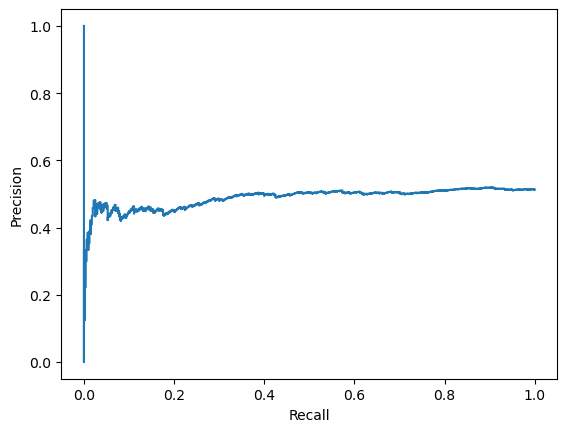

In [19]:
@nb.njit
def binary_clf_curve(y_true, y_score):
    # Sort scores
    idx = np.flip(np.argsort(y_score))
    y_score = y_score[idx]
    y_true = y_true[idx]

    # Find unique value idxs
    idx = np.where(np.diff(y_score))[0]

    # Append a value for the end of the curve
    idx = np.append(idx, y_true.size - 1)

    # Acucmulate TP with decreasing threshold
    tps = np.cumsum(y_true)[idx]
    fps = 1 + idx - tps

    return fps, tps, y_score[idx]


# @nb.njit
def precision_recall_curve(fps, tps, thresholds):
    ps = tps + fps
    # Initialize the result array with zeros to make sure that precision[ps == 0]
    # does not contain uninitialized values.
    precision = np.zeros_like(tps)
    np.divide(tps, ps, out=precision, where=(ps != 0))

    # When no positive label in y_true, recall is set to 1 for all thresholds
    # tps[-1] == 0 <=> y_true == all negative labels
    if tps[-1] == 0:
        recall = np.ones_like(tps)
    else:
        recall = tps / tps[-1]

    # reverse the outputs so recall is decreasing
    sl = slice(None, None, -1)
    return np.hstack((precision[sl], 1)), np.hstack((recall[sl], 0)), thresholds[sl]


def roc_curve(fps, tps, thresholds, drop_intermediate=True):
    # Attempt to drop thresholds corresponding to points in between and
    # collinear with other points. These are always suboptimal and do not
    # appear on a plotted ROC curve (and thus do not affect the AUC).
    # Here np.diff(_, 2) is used as a "second derivative" to tell if there
    # is a corner at the point. Both fps and tps must be tested to handle
    # thresholds with multiple data points (which are combined in
    # _binary_clf_curve). This keeps all cases where the point should be kept,
    # but does not drop more complicated cases like fps = [1, 3, 7],
    # tps = [1, 2, 4]; there is no harm in keeping too many thresholds.
    if drop_intermediate and len(fps) > 2:
        optimal_idxs = np.where(
            np.r_[True, np.logical_or(np.diff(fps, 2), np.diff(tps, 2)), True]
        )[0]
        fps = fps[optimal_idxs]
        tps = tps[optimal_idxs]
        thresholds = thresholds[optimal_idxs]

    # Add an extra threshold position
    # to make sure that the curve starts at (0, 0)
    tps = np.r_[0, tps]
    fps = np.r_[0, fps]
    thresholds = np.r_[thresholds[0] + 1, thresholds]

    if fps[-1] <= 0:
        fpr = np.repeat(np.nan, fps.shape)
    else:
        fpr = fps / fps[-1]

    if tps[-1] <= 0:
        tpr = np.repeat(np.nan, tps.shape)
    else:
        tpr = tps / tps[-1]

    return fpr, tpr, thresholds


fps, tps, thresholds = binary_clf_curve(y_true, y_pred)
precision, recall, _ = precision_recall_curve(fps, tps, thresholds)


display = metrics.PrecisionRecallDisplay(precision=precision, recall=recall)
display.plot()

In [28]:
import pandas as pd


@nb.njit
def confusion_matrix(y_true, y_pred):
    num_classes = len(np.unique(y_true))
    result = np.zeros((num_classes, num_classes))
    for i in range(len(y_true)):
        result[y_true[i]][y_pred[i]] += 1
    
    return result


@nb.njit
def gini_coefficient(y_true, y_prob):
    """
    Original author CMPM 
    https://www.kaggle.com/cpmpml/extremely-fast-gini-computation
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini


confusion_matrix((y_pred > 0.5).astype(np.int), y_true.astype(np.int))

/tmp/ipykernel_17010/761173405.py:35: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



array([[226., 261.],
       [253., 260.]])

In [29]:
gini_coefficient(y_pred > 0.5, y_true)

-0.025973558125292673

In [21]:
import cudf as cd

y_actu = cd.Series([2, 0, 2, 2, 0, 1, 1, 2, 2, 0, 1, 2], name='Actual')
y_pred = cd.Series([0, 0, 2, 1, 0, 2, 1, 0, 2, 0, 2, 2], name='Predicted')
df_confusion = cd.crosstab(y_actu, y_pred)

df_confusion

AttributeError: module 'cudf' has no attribute 'crosstab'

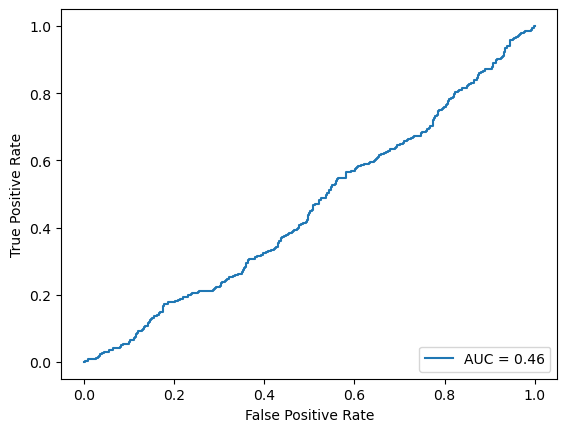

In [4]:
from sklearn.metrics._ranking import _binary_clf_curve
from sklearn import metrics

fps, tps, thresholds = _binary_clf_curve(
    y_true, y_pred, pos_label=1
)

state = BinaryCurveState(thresholds, tps, fps)

# state.plot_roc_curve(plotly=True)

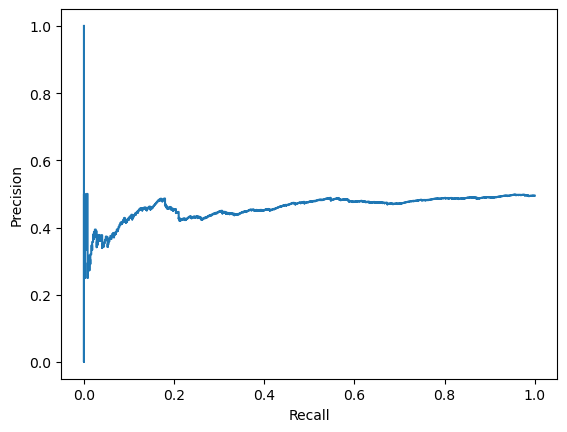

In [6]:
state.plot_pr_curve(plotly=False)

In [5]:
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)

metrics.auc(fpr, tpr)

0.4755276084417351

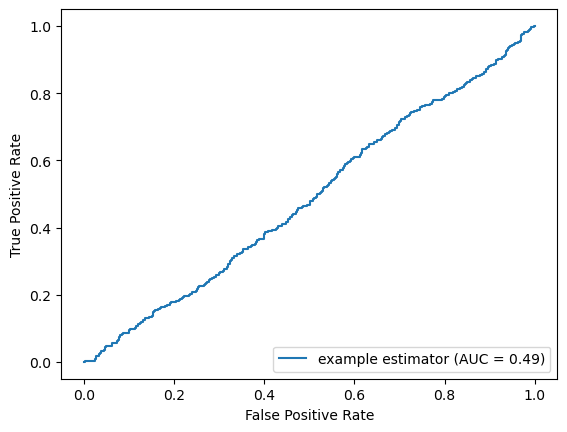

In [14]:
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=metrics.auc(fpr, tpr), 
                          estimator_name='example estimator')

display.plot()

In [15]:
import plotly.express as px

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={metrics.auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    # width=1000, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)
fig.update_layout(autosize=True)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

In [9]:
import plotly.graph_objects as go
from sklearn.metrics import roc_curve

# Calculate the true positive rate and false positive rate at various thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# Plot the resulting points as a scatter plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr))

# Customize the appearance of the curve
fig.update_traces(mode='lines+markers',
                  line=dict(color='blue', width=2),
                  marker=dict(size=10, color='red'))

# Show the figure
fig.show()

In [10]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=fpr,
        y=tpr,
        mode="lines",
        name="ROC",
        marker=dict(
            size=6,
            color="blue",
        ),
    )
)

fig.update_layout(yaxis_title="True Positive Rate", xaxis_title="False Positive Rate", showlegend=True)

fig.show()